# Побудова моделі-прототипа. EDA датасету BigMart Sales

### Знайомство з даними

In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
from sklearn.utils import estimator_html_repr
from scripts.mod_07_topic_13_transformer import VisRatioEstimator

In [2]:
data = pd.read_csv('../datasets/mod_07_topic_13_bigmart_data.csv')
data.sample(10, random_state=42)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7503,FDI28,14.300,Low Fat,0.026300,Frozen Foods,79.4302,OUT013,1987,High,Tier 3,Supermarket Type1,1743.0644
2957,NCM17,7.930,Low Fat,0.071136,Health and Hygiene,42.7086,OUT046,1997,Small,Tier 1,Supermarket Type1,356.8688
7031,FDC14,14.500,Regular,0.041313,Canned,42.0454,OUT049,1999,Medium,Tier 1,Supermarket Type1,377.5086
1084,DRC36,NaN,Regular,0.044767,Soft Drinks,173.7054,OUT027,1985,Medium,Tier 3,Supermarket Type3,5778.4782
856,FDS27,10.195,Regular,0.012456,Meat,197.5110,OUT035,2004,Small,Tier 2,Supermarket Type1,2356.9320
4304,DRK12,9.500,Low Fat,0.041951,Soft Drinks,32.4900,OUT049,1999,Medium,Tier 1,Supermarket Type1,865.5400
2132,FDO25,NaN,Low Fat,0.126832,Canned,209.0270,OUT027,1985,Medium,Tier 3,Supermarket Type3,4613.9940
1385,FDB58,10.500,Regular,0.013551,Snack Foods,142.0154,OUT018,2009,Medium,Tier 3,Supermarket Type2,2410.8618
5239,FDY48,14.000,Low Fat,0.023832,Baking Goods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1948.1308
6516,NCP42,8.510,Low Fat,0.016176,Household,192.1478,OUT018,2009,Medium,Tier 3,Supermarket Type2,1937.4780


### Перевірка типів даних і відсутніх значень

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Побудова моделі-прототипа. Підготовка й обробка даних

### Очистка даних. Генерація ознак

In [4]:
data['Outlet_Establishment_Year'] = 2013 - data['Outlet_Establishment_Year']

In [5]:
data['Item_Visibility'] = (data['Item_Visibility']
                           .mask(data['Item_Visibility'].eq(0), np.nan))

data['Item_Visibility_Avg'] = (data
                               .groupby(['Item_Type',
                                         'Outlet_Type'])['Item_Visibility']
                               .transform('mean'))

data['Item_Visibility'] = (
    data['Item_Visibility'].fillna(data['Item_Visibility_Avg']))

data['Item_Visibility_Ratio'] = (
    data['Item_Visibility'] / data['Item_Visibility_Avg'])

data[['Item_Visibility', 'Item_Visibility_Ratio']].describe()

,Item_Visibility,Item_Visibility_Ratio
count,8523.000000,8523.000000
mean,0.070440,1.000000
std,0.048885,0.643141
min,0.003575,0.053965
25%,0.033085,0.489270
50%,0.060700,0.891396
75%,0.096335,1.367361
max,0.328391,3.418374


In [6]:
data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [7]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'})

In [8]:
data['Item_Identifier_Type'] = data['Item_Identifier'].str[:2]

data[['Item_Identifier', 'Item_Identifier_Type', 'Item_Type']].head()

,Item_Identifier,Item_Identifier_Type,Item_Type
0,FDA15,FD,Dairy
1,DRC01,DR,Soft Drinks
2,FDN15,FD,Meat
3,FDX07,FD,Fruits and Vegetables
4,NCD19,NC,Household


### Розбиття на тренувальну і тестову вибірки

In [9]:
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

In [10]:
X_train_num, X_test_num, X_train_cat,  X_test_cat, y_train, y_test = (
    train_test_split(
        data_num.drop(['Item_Outlet_Sales',
                       'Item_Visibility_Avg'], axis=1),
        data_cat.drop('Item_Identifier', axis=1),
        data['Item_Outlet_Sales'],
        test_size=0.2,
        random_state=42))

### Відновлення відсутніх значень

In [11]:
num_imputer = SimpleImputer().set_output(transform='pandas')

X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

In [12]:
cat_imputer = SimpleImputer(
    strategy='most_frequent').set_output(transform='pandas')

X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)

### Кодування категоріальних змінних

In [13]:
enc_auto = TargetEncoder(random_state=42).set_output(transform='pandas')

X_train_cat = enc_auto.fit_transform(X_train_cat, y_train)
X_test_cat = enc_auto.transform(X_test_cat)

In [14]:
X_train_concat = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_concat = pd.concat([X_test_num, X_test_cat], axis=1)

X_train_concat.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Visibility_Ratio,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_Type
549,9.500,0.035206,171.3448,14.0,0.522019,2238.717144,2313.314771,2396.339935,2322.325498,1923.240458,2349.148360,2249.390936
7757,18.000,0.047473,170.5422,11.0,0.797281,2185.153492,2242.978703,2235.553393,2307.426590,2345.791359,2330.820050,2134.228026
764,17.600,0.076122,111.7202,16.0,1.338587,2239.327320,2273.782538,2281.275956,1942.398659,1889.358447,2330.820050,2250.249120
6867,8.325,0.029845,41.6138,11.0,0.442534,2146.154980,2322.811898,2227.452476,2263.075687,2319.032125,2318.980798,2212.157250
2716,12.850,0.137228,155.5630,16.0,2.086298,2146.154980,2272.157755,2267.795479,1911.170252,1874.494379,2318.980798,2212.157250


# Побудова й оцінка моделі-прототипа

### Побудова базової моделі

In [15]:
clf = (RandomForestRegressor(
    n_jobs=-1,
    random_state=42)
    .fit(X_train_concat,
         y_train))

pred_clf = clf.predict(X_test_concat)

rmse_clf = root_mean_squared_error(y_test, pred_clf)

print(f"Prototype's RMSE on test: {rmse_clf:.1f}")

Prototype's RMSE on test: 1047.4


### Важливість ознак. Відбір ознак у конвеєр

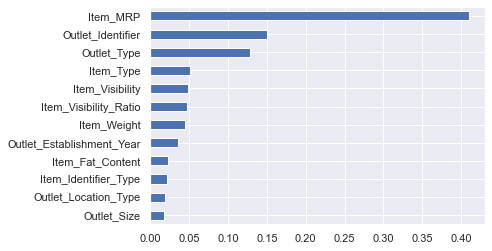

In [16]:
sns.set_theme()

(pd.Series(
    data=clf.feature_importances_,
    index=X_train_concat.columns)
    .sort_values(ascending=True)
    .plot
    .barh())

plt.show()

# ML-конвеєр. Особливості реалізації

### Створення нестандартного трансформера

In [17]:
vis_est = VisRatioEstimator()

data = (data.rename(columns={
    'Item_Visibility_Ratio': 'Item_Visibility_Ratio_prev'}))

data = vis_est.fit_transform(data)

(data[['Item_Visibility_Ratio_prev', 'Item_Visibility_Ratio']]
 .sample(10, random_state=42))

,Item_Visibility_Ratio_prev,Item_Visibility_Ratio
7503,0.402694,0.402694
2957,1.319377,1.319377
7031,0.611682,0.611682
1084,0.700654,0.700654
856,0.219033,0.219033
4304,0.663149,0.663149
2132,2.033351,2.033351
1385,0.206023,0.206023
5239,0.341605,0.341605
6516,0.262587,0.262587


# Побудова конвеєра

In [18]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder(random_state=42))])

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer())])

preprocessor = (ColumnTransformer(
    transformers=[
        ('cat',
         cat_transformer,
         make_column_selector(dtype_include=object)),
        ('num',
         num_transformer,
         make_column_selector(dtype_include=np.number))],
    n_jobs=-1,
    verbose_feature_names_out=False)
    .set_output(transform='pandas'))

model_pipeline = Pipeline(steps=[
    ('vis_estimator', VisRatioEstimator()),
    ('pre_processor', preprocessor),
    ('reg_estimator', RandomForestRegressor(
        n_jobs=-1,
        random_state=42))])

In [19]:
with open('../derived/mod_07_topic_13_mlpipe.html', 'w', encoding='utf-8') as fl:
    fl.write(estimator_html_repr(model_pipeline))

with open('../models/mod_07_topic_13_mlpipe.joblib', 'wb') as fl:
    joblib.dump(model_pipeline, fl)

### Відновлення даних. Розбивка на тренувальну і тестову вибірки

In [20]:
data.drop([
    'Item_Visibility_Avg',
    'Item_Visibility_Ratio_prev',
    'Item_Visibility_Ratio',
    'Item_Identifier_Type'],
    axis=1,
    inplace=True)

data.sample(10, random_state=42)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7503,FDI28,14.300,Low Fat,0.026300,Frozen Foods,79.4302,OUT013,26,High,Tier 3,Supermarket Type1,1743.0644
2957,NCM17,7.930,Low Fat,0.071136,Health and Hygiene,42.7086,OUT046,16,Small,Tier 1,Supermarket Type1,356.8688
7031,FDC14,14.500,Regular,0.041313,Canned,42.0454,OUT049,14,Medium,Tier 1,Supermarket Type1,377.5086
1084,DRC36,NaN,Regular,0.044767,Soft Drinks,173.7054,OUT027,28,Medium,Tier 3,Supermarket Type3,5778.4782
856,FDS27,10.195,Regular,0.012456,Meat,197.5110,OUT035,9,Small,Tier 2,Supermarket Type1,2356.9320
4304,DRK12,9.500,Low Fat,0.041951,Soft Drinks,32.4900,OUT049,14,Medium,Tier 1,Supermarket Type1,865.5400
2132,FDO25,NaN,Low Fat,0.126832,Canned,209.0270,OUT027,28,Medium,Tier 3,Supermarket Type3,4613.9940
1385,FDB58,10.500,Regular,0.013551,Snack Foods,142.0154,OUT018,4,Medium,Tier 3,Supermarket Type2,2410.8618
5239,FDY48,14.000,Low Fat,0.023832,Baking Goods,103.1332,OUT018,4,Medium,Tier 3,Supermarket Type2,1948.1308
6516,NCP42,8.510,Low Fat,0.016176,Household,192.1478,OUT018,4,Medium,Tier 3,Supermarket Type2,1937.4780


In [21]:
data.to_pickle('../derived/mod_07_topic_13_bigmart_data_upd.pkl.gz')

In [22]:
X_train, X_test, y_train, y_test = (
    train_test_split(
        data.drop(['Item_Identifier',
                   'Item_Outlet_Sales'],
                  axis=1),
        data['Item_Outlet_Sales'],
        test_size=0.2,
        random_state=42))

X_train.head(10)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
549,9.500,Regular,0.035206,Fruits and Vegetables,171.3448,OUT049,14,Medium,Tier 1,Supermarket Type1
7757,18.000,Low Fat,0.047473,Household,170.5422,OUT045,11,NaN,Tier 2,Supermarket Type1
764,17.600,Regular,0.076122,Meat,111.7202,OUT046,16,Small,Tier 1,Supermarket Type1
6867,8.325,Low Fat,0.029845,Fruits and Vegetables,41.6138,OUT045,11,NaN,Tier 2,Supermarket Type1
2716,12.850,Low Fat,0.137228,Snack Foods,155.5630,OUT046,16,Small,Tier 1,Supermarket Type1
5404,NaN,Regular,0.099780,Fruits and Vegetables,225.2088,OUT019,28,Small,Tier 1,Grocery Store
6657,NaN,Low Fat,0.014009,Dairy,171.3422,OUT019,28,Small,Tier 1,Grocery Store
1372,12.150,Regular,0.132831,Fruits and Vegetables,190.6872,OUT017,6,NaN,Tier 2,Supermarket Type1
2992,13.850,Low Fat,0.031339,Others,41.0480,OUT046,16,Small,Tier 1,Supermarket Type1
333,NaN,Regular,0.056597,Snack Foods,230.9984,OUT027,28,Medium,Tier 3,Supermarket Type3


### Навчання й оцінка моделі в конвеєрі

In [23]:
model = model_pipeline.fit(X_train, y_train)
model

Pipeline(steps=[('vis_estimator', VisRatioEstimator()),
                ('pre_processor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   TargetEncoder(random_state=42))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001BB7F242C50>),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001BB0002AFD0>)],
                                   verbose_feature_names_out=False)),
                ('reg_estimator',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

In [24]:
pred_pipe = model.predict(X_test)
rmse_pipe = root_mean_squared_error(y_test, pred_pipe)

print(f"Pipe's RMSE on test: {rmse_pipe:.1f}")

Pipe's RMSE on test: 1048.5


### Крос-валідація моделі в конвеєрі

In [25]:
cv_results = cross_val_score(
    estimator=model_pipeline,
    X=X_train,
    y=y_train,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1)

rmse_cv = np.abs(cv_results).mean()

print(f"Pipe's RMSE on CV: {rmse_cv:.1f}")

Pipe's RMSE on CV: 1128.6
